# This notebook is used to study:
#### - The effect of the distance_param (in the shower direction estimator) to the reconstructed angle of a shower
#### - The resolution of the angle reconstruction

In [1]:
import sys
#sys.path.append("/home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/lartpc_mlreco3d")   # locally
#sys.path.append("/home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/pi0_reco")          # locally
#sys.path.append("/u/nu/rberner/pi0_reconstruction/lartpc_mlreco3d")                             # nu-gpu0x
#sys.path.append("/u/nu/rberner/pi0_reconstruction/pi0_reco")                                    # nu-gpu0x
sys.path.append("../lartpc_mlreco3d")                                                            # JupyterLab
sys.path.append("../pi0_reco")                                                                   # JupyterLab

In [2]:
io_cfg = '''
iotool:
  batch_size: 1
  shuffle: False
  num_workers: 4
  collate_fn: CollateSparse
  dataset:
    name: LArCVDataset
    data_keys:
      #- /gpfs/slac/staas/fs1/g/neutrino/kterao/data/mpvmpr_2020_01_v04/test.root
      - ../data/test.root
    limit_num_files: 1
    schema:
      input_data:
        - parse_sparse3d_scn
        - sparse3d_pcluster
      segment_label:
        - parse_sparse3d_scn
        - sparse3d_pcluster_semantics
      semantics:
        - parse_sparse3d_scn
        - sparse3d_pcluster_semantics
      dbscan_label:
        - parse_cluster3d_clean_full
        - cluster3d_pcluster
        - particle_corrected
        - sparse3d_pcluster_semantics
      particles_label:
        - parse_particle_points
        - sparse3d_pcluster
        - particle_corrected
      particles:
        - parse_particle_asis
        - particle_corrected
        - cluster3d_pcluster
      cluster_label:
        - parse_cluster3d_full
        - cluster3d_pcluster
        - particle_corrected
'''

# Convert the string to a dictionary
#import yaml
#cfg = yaml.load(cfg,Loader=yaml.Loader)

# Pre-process configuration
#from mlreco.main_funcs import process_config
#process_config(cfg)

In [3]:
from mlreco.main_funcs import prepare, apply_event_filter
from mlreco.utils.gnn.evaluation import node_assignment, node_assignment_bipartite, edge_assignment_score, clustering_metrics, node_assignment_score

In [4]:
# Configuration of the reconstruction chain
chain_cfg = '''
name: pi0_chain_fiducialized
#net_cfg: /home/rberner/cernbox/PhD/pi0_reconstruction/reco_software/config_files/fullChain_gnn_dbscan_cpu_X1.cfg      # locally
#net_cfg: /u/nu/rberner/pi0_reconstruction/config_files/fullChain_gnn_dbscan_cpu.cfg                                   # nu-gpu0x
net_cfg: ../config_files/fullChain_gnn_dbscan_gpu0.cfg                                                                 # JupyterLab
#net_cfg: ../config_files/fullChain_gnn_dbscan_gpu0.cfg                                                                 # JupyterLab
segment:                   uresnet                     # label, uresnet
deghost:                   label                       # label, uresnet
charge2energy:                                         # null, constant, average(, full, enet)
charge2energy_cst:         0.0082                      # energy response constant (0.0082 for mask, 0.0052 for uresnet)
charge2energy_average:     0.877                       # energy response average (1.3693 for mask, 0.877 for uresnet)
shower_start:              gnn                         # label, ppn, gnn (if using gnn, use uresnet)
shower_fragment:           gnn                         # label, dbscan, gnn
shower_direction:          pca                         # label, pca, cent
shower_cluster:            gnn                         # label, cone, gnn
shower_cluster_params:
  IP: 40
  Distance: 300
shower_energy:             pixel_sum                   # label, pixel_sum
shower_match:              proximity                         # label, proximity, ppn
refit_dir:                 true                        # true, false
refit_cone:                true                        # true, false
fiducialize:               14                          # Number of pixels to be removed from edge of LAr volume (pixel pitch: 3mm)
PPN_score_thresh:          [0.9, 0.9, 0.9, 0.9, 0.9]   # For PPN predictions to be classified as shower, track, michel, delta or LEScatter, respectively
'''
import yaml
chain_cfg = yaml.load(chain_cfg,Loader=yaml.Loader)

In [5]:
# Progress bar
from IPython.display import HTML, display
def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

In [6]:
class Results(object):
    '''
    Class for the storage of result acquired during chain.run_loop() process.
    The attributes are added in a dynamic way.
    This class can be used as:
    res = Results()
    res.attribute = someobject
    Use Results.__dict__ to show attributes.
    '''

    # Defined attributes
    # -------------------------------------
    '''
    ev_id

    # FOR ALL TRUE PI0 DECAYS IN THE EVEN
    true_n_pi0s
    true_n_gammas
    true_pi0_track_ids
    true_gamma_particle_ids
    true_gamma_group_ids
    true_gamma_mom
    true_gamma_dir
    true_gamma_first_step
    true_gamma_pos
    true_gamma_ekin
    true_gamma_edep
    true_gamma_voxels
    true_gamma_n_voxels
    true_OOFV                   # If at least one edep is at boundary pixels -> store shower_number in this list
    true_gamma_angle
    true_pi0_mass

    # FOR ALL SHOWER INSTANCES WHICH GOT MATCHED TO A PI0 DECAY IN THE EVEN
    reco_n_pi0
    reco_n_gammas
    reco_matches
    reco_gamma_mom
    reco_gamma_dir
    reco_gamma_start
    reco_gamma_edep
    reco_gamma_pid
    reco_gamma_voxels_mask      # array of n lists (n=number of reco showers) which contain voxel_mask indices
    reco_gamma_n_voxels_mask    # length of gamma_voxels_mask
    reco_gamma_voxels           # array of n lists (n=number of reco showers) which contain voxel coordinates
    reco_gamma_n_voxels         # length of gamma_voxels
    reco_OOFV                   # If at least one edep is at boundary pixels -> store shower_number in this list
    reco_gamma_angle
    reco_pi0_mass
    
    # FOR ALL SHOWER CLUSTER INSTANCES IN THE EVENT
    clusters_n_clusters
    clusters_start
    clusters_dir
    clusters_voxels
    clusters_energy
    '''
    
    pass

In [7]:
# Class that contains the clusters direction information for different distance_params
class Directions(object):
    '''
    Class for the storage of the cluster directions for different distance parameters, acquired during chain.run_loop() process.
    The attributes are added in a dynamic way.
    This class can be used as:
    direction = Directions()
    direction.attribute = someobject
    Use Directions.__dict__ to show attributes.
    '''

    # Defined attributes
    # -------------------------------------
    '''
    event_id
    
    true_n_showers        # value which stores the number of true gamma showers in the event
    true_dir              # list of L arrays (L=number of true gamma showers), where every array stores the true shower's direction
    true_ekin:            #
    true_edep:            #
    true_first_step:      #
    
    clusters_n_clusters   # value which stores the number of clusters in the event
    clusters_start        # list of M arrays (M=number of clusters), where every array stores the cluster's start position
    clusters_dir          # list of N arrays (N=number of parameters), where every array stores the directions for cluster1, cluster2, ..., clusterM
    clusters_voxels       # list of M arrays (M=number of clusters)
    clusters_energy       # list of M values (M=number of clusters) where every number corresponds to the sum of edeps of every cluster
    
    distance_params       # list of N values, where every value is the corresponding distance_param
    '''
    
    pass

In [8]:
# Some imports
from larcv import larcv
import numpy as np
from numpy import linalg
from pi0.directions.estimator import FragmentEstimator, DirectionEstimator # explicitly used for the direction estimation

Welcome to JupyROOT 6.16/00


In [9]:
# Initialize the chain
from pi0.chain import Pi0Chain
chain = Pi0Chain(io_cfg, chain_cfg)

Initialized Pi0 mass chain, log path: masses_fiducialized_14px.csv

Config processed at: Linux slac-larcv2-rberner-20200403.0 3.10.0-1062.4.1.el7.x86_64 #1 SMP Fri Oct 18 17:15:30 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux

$CUDA_VISIBLE_DEVICES="0"

{   'iotool': {   'batch_size': 1,
                  'collate_fn': 'CollateSparse',
                  'dataset': {   'data_keys': ['../data/test.root'],
                                 'limit_num_files': 1,
                                 'name': 'LArCVDataset',
                                 'schema': {   'cluster_label': [   'parse_cluster3d_full',
                                                                    'cluster3d_pcluster',
                                                                    'particle_corrected'],
                                               'dbscan_label': [   'parse_cluster3d_clean_full',
                                                                   'cluster3d_pcluster',
                            

In [10]:
# Define a list with the results obtained by run_loop()
ResultsList = []


# Define a list with the directions (for different distance_params) of the showers
DirectionsList = []


# Loop over dataset
data_size = 10000 #len(chain.hs.data_io)
out       = display(progress(0,data_size,'images'),display_id=True)

for event in range(data_size):
    
    chain.run_loop()


    # Instantiate Results class
    extracted_data = Results()


    # Add members of the Results class
    extracted_data.event_id                    = chain.true_info['ev_id']
    assert chain.true_info['ev_id']            == chain.event['index']

    extracted_data.true_n_pi0s                 = chain.true_info['n_pi0']
    extracted_data.true_n_gammas               = chain.true_info['n_gammas']
    extracted_data.true_pi0_track_ids          = chain.true_info['pi0_track_ids']
    extracted_data.true_gamma_particle_ids     = chain.true_info['gamma_particle_ids']
    extracted_data.true_gamma_group_ids        = chain.true_info['gamma_group_ids']
    extracted_data.true_gamma_mom              = chain.true_info['gamma_mom']
    extracted_data.true_gamma_dir              = chain.true_info['gamma_dir']
    extracted_data.true_gamma_first_step       = chain.true_info['gamma_first_step']
    extracted_data.true_gamma_pos              = chain.true_info['gamma_pos']
    extracted_data.true_gamma_ekin             = chain.true_info['gamma_ekin']
    extracted_data.true_gamma_edep             = chain.true_info['gamma_edep']
    extracted_data.true_gamma_voxels           = chain.true_info['gamma_voxels']
    extracted_data.true_gamma_n_voxels         = chain.true_info['gamma_n_voxels']
    extracted_data.true_OOFV                   = chain.true_info['OOFV']
    extracted_data.true_gamma_angle            = chain.true_info['gamma_angle'] # [rad]
    extracted_data.true_pi0_mass               = chain.true_info['pi0_mass']

    extracted_data.reco_n_pi0s                 = chain.reco_info['n_pi0']
    extracted_data.reco_n_gammas               = chain.reco_info['n_gammas']
    extracted_data.reco_matches                = chain.reco_info['matches']
    extracted_data.reco_gamma_mom              = chain.reco_info['gamma_mom']
    extracted_data.reco_gamma_dir              = chain.reco_info['gamma_dir']
    extracted_data.reco_gamma_start            = chain.reco_info['gamma_start']
    extracted_data.reco_gamma_edep             = chain.reco_info['gamma_edep']
    extracted_data.reco_gamma_pid              = chain.reco_info['gamma_pid']
    extracted_data.reco_gamma_voxels_mask      = chain.reco_info['gamma_voxels_mask']
    extracted_data.reco_gamma_n_voxels_mask    = chain.reco_info['gamma_n_voxels_mask']
    extracted_data.reco_gamma_voxels           = chain.reco_info['gamma_voxels']
    extracted_data.reco_gamma_n_voxels         = chain.reco_info['gamma_n_voxels']
    extracted_data.reco_OOFV                   = chain.reco_info['OOFV']
    extracted_data.reco_gamma_angle            = chain.reco_info['gamma_angle'] # [rad]
    extracted_data.reco_pi0_mass               = chain.reco_info['pi0_mass']
    
        
    #for sh in range(extracted_data.true_n_gammas):
        #print(' true start: ', extracted_data.true_gamma_first_step[sh])
        #print(' true dir: ', extracted_data.true_gamma_dir[sh])
        #print(' ------------------------------------------------ ')


    extracted_data.clusters_n_clusters = len(chain.output['showers'])
    extracted_data.clusters_start      = []
    extracted_data.clusters_dir        = []
    extracted_data.clusters_voxels     = []
    extracted_data.clusters_energy     = []
    for i, shower in enumerate(chain.output['showers']):
        extracted_data.clusters_start.append(shower.start)
        extracted_data.clusters_dir.append(shower.direction)
        extracted_data.clusters_voxels.append(shower.voxels)
        extracted_data.clusters_energy.append(shower.energy)


    # Append the extracted data to the ResultsList
    ResultsList.append(extracted_data)
    
    
    
    # Select events with exactly 1 true pi0 -> gamma+gamma and two 
    if chain.true_info['n_gammas'] != 2:
        out.update(progress(event,data_size,'images'))
        continue
    if len(chain.output['showers']) != 2:
        out.update(progress(event,data_size,'images'))
        continue

    
    
    # OBTAIN THE DIRECTIONS FOR EACH CLUSTER, FOR DIFFERENT DISTANCE_PARAMS IN THE DIRECTION ESTIMATE FUNCTION
    # ==========================================================================================================
    # Instantiate Direction class
    direction_data = Directions()

    # Add members of the Directions class
    direction_data.event_id            = chain.true_info['ev_id']
    direction_data.true_n_showers      = chain.true_info['n_gammas']
    direction_data.true_dir            = chain.true_info['gamma_dir']
    direction_data.true_ekin           = chain.true_info['gamma_ekin']
    direction_data.true_edep           = chain.true_info['gamma_edep']
    direction_data.true_first_step     = chain.true_info['gamma_first_step']
    direction_data.clusters_n_clusters = len(chain.output['showers'])
    direction_data.clusters_start      = []
    direction_data.clusters_dir        = []
    direction_data.clusters_voxels     = []
    direction_data.clusters_energy     = []
    direction_data.distance_params     = []

    for i, shower in enumerate(chain.output['showers']):
        direction_data.clusters_start.append(shower.start)
        direction_data.clusters_voxels.append(shower.voxels)
        direction_data.clusters_energy.append(shower.energy)

    algo          = chain.cfg['shower_direction']
    shower_points = chain.output['energy'][chain.output['shower_mask']]
    starts        = np.array([s.start for s in chain.output['showers']])
    fragments     = [shower_points[inds] for inds in chain.output['shower_fragments']]

    num_values = 10   # How many different parameters do you want to test
    min_dist   = 4    # Minimum value
    delta_dist = 2   # Value to be added to the distance parameter
    
    dirs_list = [] # to store the directions for every distance_param
    for i in range(num_values):

        # Obtain distance_param
        #if i==(num_values-1):
        #    distance_param = float('inf')
        #else:
        #    distance_param = min_dist + i*delta_dist
        distance_param = min_dist + i*delta_dist

        # Calculate direction
        try:
            direction_data.distance_params.append(distance_param)
            res = chain.dir_est.get_directions(starts, fragments, max_distance=float(distance_param), mode=algo) # float('inf')
            dirs_list.append(res)

            #print('\n res: ')
            #print(res)
        except AssertionError as err: # Cluster was not found for at least one primary
            print('Error in direction reconstruction:', err)
            res = [[0., 0., 0.] for _ in range(len(chain.output['showers']))]

        # shower.direction should be the direction where distance_param = float('inf')
        if i==(num_values-1):
            for i, shower in enumerate(chain.output['showers']):
                shower.direction = res[i]

    direction_data.clusters_dir.append(dirs_list)

    # Append the extracted data to the ResultsList
    DirectionsList.append(direction_data)



    # Draw event
    '''
    # Draw the last event if requested
    #i_draw    = 0
    #n_draw    = 0
    #if 'matches' in chain.output and len(chain.output['matches']) and i_draw < n_draw:
    #    chain.draw()
    #    i_draw += 1
    #chain.draw()
    draw_eventIDs = []
    if chain.true_info['ev_id'] in draw_eventIDs:
        chain.draw()
    '''
    #try:
    #    chain.draw()
    #except:
    #    pass

    #draw_eventIDs = [3,53,54,68,70,71,73,76,78,79,80,83,84]
    #if chain.true_info['ev_id'] in draw_eventIDs:
    #    chain.draw()
    
    #chain.draw()
    
    
    # Print to screen
    print_information = False
    if print_information:
        #if extracted_data.true_n_pi0s>0 or extracted_data.reco_n_pi0s>0:
        print(' event_id: \t \t ',           extracted_data.event_id)
        print(' true_n_pi0s: \t \t ',        extracted_data.true_n_pi0s)
        print(' reco_n_pi0s: \t \t ',        extracted_data.reco_n_pi0s)
        #print(' true_gamma_edep: \t ',       extracted_data.true_gamma_edep)
        #print(' reco_gamma_edep: \t ',       extracted_data.reco_gamma_edep)
        print(' true_gamma_dir: \t ',        extracted_data.true_gamma_dir)
        print(' reco_gamma_dir: \t ',        extracted_data.reco_gamma_dir)
        #print(' true_gamma_angle [rad]: ',   extracted_data.true_gamma_angle)
        #print(' reco_gamma_angle [rad]: ',   extracted_data.reco_gamma_angle)
        #print(' true_OOFV: \t \t ',          extracted_data.true_OOFV)
        #print(' reco_OOFV: \t \t ',          extracted_data.reco_OOFV)
        #print(' reco_pi0_mass: \t ',         extracted_data.reco_pi0_mass)
        #print(' ------------------------------------------------------ ')
    

    # Update progress bar
    out.update(progress(event,data_size,'images'))
out.update(progress(data_size,data_size,'images'))

< 2 shower start points found in event 0
< 2 shower start points found in event 2
< 2 shower start points found in event 3
< 2 shower start points found in event 6
< 2 shower start points found in event 9
No pi0 found in event 10
< 2 shower start points found in event 11
No pi0 found in event 12
< 2 shower start points found in event 17
No pi0 found in event 18
< 2 shower start points found in event 19
No pi0 found in event 21
No pi0 found in event 22
No pi0 found in event 27
No pi0 found in event 28
< 2 shower start points found in event 29
< 2 shower start points found in event 30
No pi0 found in event 33
< 2 shower start points found in event 34
No pi0 found in event 35
No pi0 found in event 38
No pi0 found in event 39
< 2 shower start points found in event 40
No pi0 found in event 41
No pi0 found in event 42
No pi0 found in event 43
No pi0 found in event 49
No pi0 found in event 50
No pi0 found in event 53
No pi0 found in event 55
No pi0 found in event 56
< 2 shower start points fo

# Event Selection

In [11]:
print(' MAKE SELECTION ')

 MAKE SELECTION 


# Analyse Directions of Showers

In [12]:
import math

DistanceParam_List = []


class DistanceParam_Analysis(object):
    '''
    angles
    true_edep
    true_ekin
    clusters_energy
    distance_params
    '''
    pass

class DistanceParam_Results(object):
    '''
    event_id
    angle       # angle between true_gamma and reconstructed cluster_gamma [deg]
    true_ekin
    true_edep
    reco_edep   # energy of the reconstructed cluster_gamma [MeV]
    '''
    pass

#n_params        = len(DirectionsList[0].distance_params)
#angles          = []
#true_edep       = []
#true_ekin       = []
#clusters_energy = []
#distance_params = []


for i, entry in enumerate(DirectionsList):
    #if i>1: break # TODO: DELETE THIS
    # TODO: IF >0 VARIABLES IN THIS ENTRY ARE nan: CONTINUE
    '''
    print(' i: ', i)
    print(' event_id:        ', entry.event_id)
    #print(' true showers:    ', entry.true_n_showers)
    #print(' n_clust:         ', entry.clusters_n_clusters)
    print(' true_edep:       ', entry.true_edep)
    print(' true_ekin:       ', entry.true_ekin)
    print(' clusters_energy: ', entry.clusters_energy)
    #print(' true_start:      ', entry.true_first_step)
    #print(' clusters_start:  ', entry.clusters_start)
    print(' true_dir:        ', entry.true_dir)
    print(' clusters_dir:    ', entry.clusters_dir)
    #print(' clusters_voxels: ', entry.clusters_voxels)
    print(' clusters_energy: ', entry.clusters_energy)
    print(' distance_params: ', entry.distance_params)
    '''

    # Use list comprehension to initialize matrices
    #directions = [ [ [0 for i in range(3)] for i in range(n_params) ] for i in range(entry.clusters_n_clusters) ] # array[ith cluster][jth dist_param][dir_x,dir_y,dir_z]
    #print(' directions: ', directions)
    angle_deg = [ [0 for i in range(len(entry.distance_params))] for i in range(entry.clusters_n_clusters)]
    #print(' angle_deg: ', angle_deg)
    params = [0 for i in range(len(entry.distance_params))] # array[jth dist_param]
    #print(' params: ', params)
    true_ekin = [0 for i in range(entry.true_n_showers)]
    true_edep = [0 for i in range(entry.true_n_showers)]
    clusters_energy = [0 for i in range(entry.clusters_n_clusters)]
    
    '''
    print(' dir[0][0][0]: ', entry.clusters_dir[0][0][0])
    print(' dir[0][1][0]: ', entry.clusters_dir[0][1][0])
    print(' dir[0][2][0]: ', entry.clusters_dir[0][2][0])
    print(' dir[0][3][0]: ', entry.clusters_dir[0][3][0])
    print(' dir[0][4][0]: ', entry.clusters_dir[0][4][0])
    print(' dir[0][5][0]: ', entry.clusters_dir[0][5][0])
    print(' dir[0][6][0]: ', entry.clusters_dir[0][6][0])
    print(' dir[0][7][0]: ', entry.clusters_dir[0][7][0])
    print(' dir[0][8][0]: ', entry.clusters_dir[0][8][0])
    print(' dir[0][9][0]: ', entry.clusters_dir[0][9][0])
    '''
    
    # To obtain the zeroth clusters direction estimated with the 6th distance_param
    #print(' dir[0][6][0]: ', entry.clusters_dir[0][6][0])
    
    # To obtain the first clusters direction estimated with the 3rd distance_param
    #print(' dir[0][3][1]: ', entry.clusters_dir[0][3][1])
    
    
    # Create matrix for distances between cluster_i and true_shower_j:
    if not (entry.clusters_n_clusters or entry.true_n_showers): continue

    # CUT: WANT TO HAVE SAME NUMBER OF TRUE GAMMAS AND TRUE CLUSTERS
    if entry.clusters_n_clusters != 2 or entry.true_n_showers != 2: continue

    dist_mat = np.ones([entry.clusters_n_clusters, entry.true_n_showers]) # columns = number of clusters, rows = number of true_gammas
    '''
    print(' clusters start positions: ')
    for cl in range(entry.clusters_n_clusters):
        print(entry.clusters_start[cl])

    print(' true gammas start positions: ')
    for gamma in range(entry.true_n_showers):
        print(entry.true_first_step[gamma])
   '''
    for cluster in range(entry.clusters_n_clusters):
        for true_gamma in range(entry.true_n_showers):
            dist_mat[cluster][true_gamma] = np.linalg.norm(entry.clusters_start[cluster]-entry.true_first_step[true_gamma])
    
    # Store assignments
    assignments = [] # list of U arrays (where U is min(n_clusters,n_true_gammas)). First array entry: cluster index, second array: true_gamma index.
    for i in range(min(dist_mat.shape)):
        indices = np.argwhere(dist_mat.min() == dist_mat)

        assignments.append(indices[0])

        dist_mat[indices[0][0],:] = 999
        dist_mat[:,indices[0][1]] = 999
        
    #print(' assignment: ', assignments)

    
    # CONTINUE HERE: clusters_dir are now lists of arrays (for every parameter!)
    # -> DEFINE ABOVE MAYBE ARRAY OF LISTS, WHERE THE ARRAY HAS LENGTH N_PARAMETERS
    # THEN IT SHOULD BE EASY TO JUST APPEND TO THE LIST OF EVERY PARAMETER-SETTINGS AND THEN DRAW EACH LIST SEPARATE
    # CHECK: IS LIST WITH PARAM 'INF' EXACTLY THE SAME AS PLOT BELOW?
    
    '''
    # Calculate angle between assigned showers
    for i, ass in enumerate(assignments):
        for param in range(len(entry.distance_params)):
            #print(' true dir: ', entry.true_dir[ass[1]])
            #print(' clust dir: ', entry.clusters_dir[0][param][ass[0]])
            angle_deg[ass[0]][param] = np.arccos(np.dot(entry.clusters_dir[0][param][ass[0]],entry.true_dir[ass[1]]))*360/(2*np.pi)
            angle_rad = np.arccos(np.dot(entry.clusters_dir[0][param][ass[0]],entry.true_dir[ass[1]]))
            #print(' angle [deg]: ', angle_deg)
            angl[ass[0]][param] = angle_deg # ORDERING: angle[cluster_nr][distance_param] and NOT angle[true_shower][distance_param]
            params[param] = entry.distance_params[param]
            #print(' angle [rad]: ', angle_rad)
        true_ekin[i] = entry.true_ekin[ass[0]]
        true_edep[i] = entry.true_edep[ass[0]]
        clusters_energy[ass[1]] = entry.clusters_energy[ass[1]]
        #print(' ----------------------------- ')
    #print(' angl: ', angl)
    #print(' params: ', params)
    '''
    
    # Calculate angle between assigned showers
    for i, ass in enumerate(assignments):
        for param in range(len(entry.distance_params)):
            #print(' true dir: ', entry.true_dir[ass[1]])
            #print(' clust dir: ', entry.clusters_dir[0][param][ass[0]])
            angle_deg[assignments[i][0]][param] = np.arccos(np.dot(entry.clusters_dir[0][param][assignments[i][0]],entry.true_dir[assignments[i][1]]))*360/(2*np.pi)
            #angle_rad = np.arccos(np.dot(entry.clusters_dir[0][param][ass[0]],entry.true_dir[ass[1]]))
            #print(' angle [deg]: ', angle_deg)
            #angl[ass[0]][param] = angle_deg # ORDERING: angle[cluster_nr][distance_param] and NOT angle[true_shower][distance_param]
            params[param] = entry.distance_params[param]
            #print(' angle [rad]: ', angle_rad)
        true_ekin[assignments[i][0]] = entry.true_ekin[assignments[i][1]]
        true_edep[assignments[i][0]] = entry.true_edep[assignments[i][1]]
        clusters_energy[assignments[i][0]] = entry.clusters_energy[assignments[i][0]]
        #print(' ----------------------------- ')
    #print(' angl: ', angl)
    #print(' params: ', params)
    
    
    
    results = DistanceParam_Results()
    
    results.event_id  = entry.event_id
    results.params    = params
    results.angles    = angle_deg
    results.true_ekin = entry.true_ekin
    results.true_edep = entry.true_edep
    results.reco_edep = entry.clusters_energy
    '''
    print(' event_id:                      ', results.event_id)
    print(' distance_params:               ', params)
    print(' angle [deg]:                   ', angle_deg)
    print(' true gamma energy [MeV]:       ', true_ekin)
    print(' true edep [MeV]:               ', true_edep)
    print(' cluster energy [MeV]:          ', results.reco_edep)
    print(' ------------------------------------------------------------------------------- ')
    '''


    DistanceParam_List.append(results)
    
    #print(' event_id:            ', entry.event_id)
    #print(' true_n_showers:      ', entry.true_n_showers)
    #print(' true_dir:            ', entry.true_dir)
    #print(' true_ekin:           ', entry.true_ekin)
    #print(' true_edep:           ', entry.true_edep)
    #print(' true_first_step:     ', entry.true_first_step)    
    #print(' clusters_n_clusters: ', entry.clusters_n_clusters)
    #print(' clusters_start:      ', entry.clusters_start)
    #print(' clusters_dir:        ', entry.clusters_dir)        # list of N arrays (N=number of parameters), where every array stores the directions for cluster1, cluster2, ..., clusterM
    #print(' clusters_voxels:     ', entry.clusters_voxels)     # list of M arrays (M=number of clusters)
    #print(' clusters_energy:     ', entry.clusters_energy)     # list of M values (M=number of clusters) where every number corresponds to the sum of edeps of every cluster
    #print(' distance_params:     ', entry.distance_params)     # list of N values, where every value is the corresponding distance_param
    #print(' -------------------------------------------------------------------------------------------------------------------------------- ')


    
    
    # TODO: TRUE_EDEP IS A DANGEROUS VARIABLE; IT MIGHT BE THE ENERGY DEPOSITION OF THE FIRST PHOTON ONLY, WITHOUT ANY DAUGHTER EDEPS OR SO. -> TRUE_EKIN DENOTES THE TRUE GAMMAS EKIN, HOWEVER, THE EDEP MIGHT BE SMALLER...
    # CHECK THAT!!!

### Produce plot whith angles as a function of parameter

In [13]:
print(' Number of parameters: ', len(DistanceParam_List[0].params))
print(' DistanceParameters:   ', DistanceParam_List[0].params)

 Number of parameters:  10
 DistanceParameters:    [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]


In [14]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

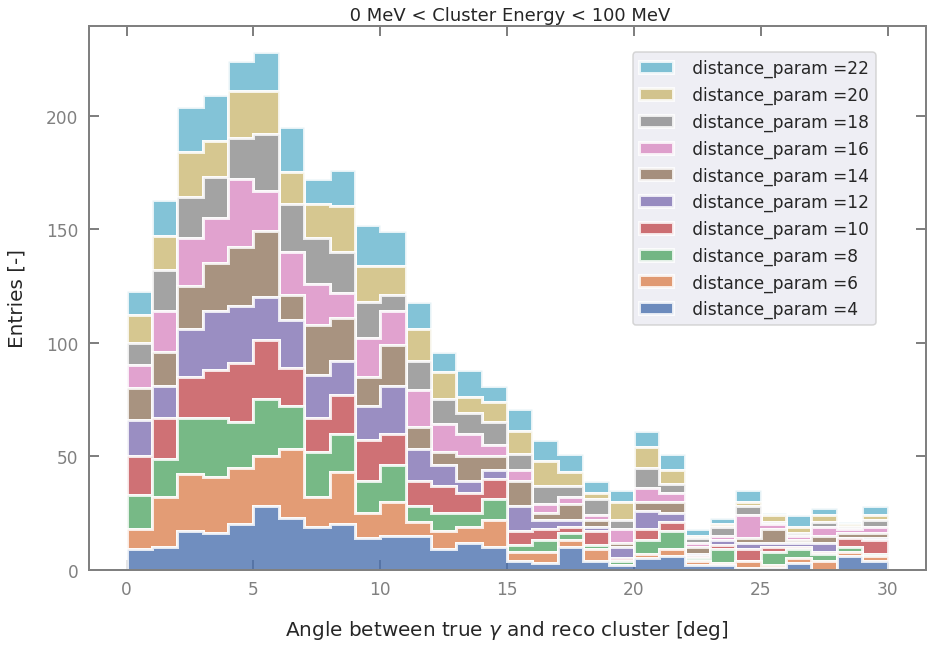

In [15]:
# Define lists for angles for corresponding energies of the cluster
angles_0_100, angles_100_200, angles_200_300, angles_300_400, angles_400_500, angles_500_inf = [], [], [], [], [], []

for i, entry in enumerate(DistanceParam_List):
    '''
    print(' i: ', i)
    print(' event_id:  ', entry.event_id)
    print(' params:    ', entry.params)
    print(' angles:    ', entry.angles)
    print(' true_ekin: ', entry.true_ekin)
    print(' true_edep: ', entry.true_edep)
    print(' reco_edep: ', entry.reco_edep)
    print(' -------------------------------------------------- ')
    '''
    for clust in range(len(entry.reco_edep)):
        if entry.reco_edep[clust]>0 and entry.reco_edep[clust]<100:
            angles_0_100.append(entry.angles[clust])
        if entry.reco_edep[clust]>100 and entry.reco_edep[clust]<200:
            angles_100_200.append(entry.angles[clust])
        if entry.reco_edep[clust]>200 and entry.reco_edep[clust]<300:
            angles_200_300.append(entry.angles[clust])
        if entry.reco_edep[clust]>300 and entry.reco_edep[clust]<400:
            angles_300_400.append(entry.angles[clust])
        if entry.reco_edep[clust]>400 and entry.reco_edep[clust]<500:
            angles_400_500.append(entry.angles[clust])
        if entry.reco_edep[clust]>500:
            angles_500_inf.append(entry.angles[clust])
        
#print(' angles_0_100: ')
#for i in range(len(angles_0_100)):
#    print(angles_0_100[i])
    

# TODO: THIS IS SUPER-DUMB, MAKE IT AS A FUNCTION OF NUMBER_OF_PARAMS
param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9 = [], [], [], [], [], [], [], [], [], []
for clust in range(len(angles_0_100)):
    param_0.append(angles_0_100[clust][0])
    param_1.append(angles_0_100[clust][1])
    param_2.append(angles_0_100[clust][2])
    param_3.append(angles_0_100[clust][3])
    param_4.append(angles_0_100[clust][4])
    param_5.append(angles_0_100[clust][5])
    param_6.append(angles_0_100[clust][6])
    param_7.append(angles_0_100[clust][7])
    param_8.append(angles_0_100[clust][8])
    param_9.append(angles_0_100[clust][9])

E_0_100 = [param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9]
#print(' E_0_100: ', E_0_100)



seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 30
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'

# Produce histogram
n, bins, patches = plt.hist(E_0_100, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=True, linewidth=3, alpha=0.8)

# Legend
#unfiducialized = 'not fiducialized'
entry_0 = ' distance_param =' + str(DistanceParam_List[0].params[0])
entry_1 = ' distance_param =' + str(DistanceParam_List[0].params[1])
entry_2 = ' distance_param =' + str(DistanceParam_List[0].params[2])
entry_3 = ' distance_param =' + str(DistanceParam_List[0].params[3])
entry_4 = ' distance_param =' + str(DistanceParam_List[0].params[4])
entry_5 = ' distance_param =' + str(DistanceParam_List[0].params[5])
entry_6 = ' distance_param =' + str(DistanceParam_List[0].params[6])
entry_7 = ' distance_param =' + str(DistanceParam_List[0].params[7])
entry_8 = ' distance_param =' + str(DistanceParam_List[0].params[8])
entry_9 = ' distance_param =' + str(DistanceParam_List[0].params[9])
plt.legend([entry_9, entry_8, entry_7, entry_6, entry_5, entry_4, entry_3, entry_2, entry_1, entry_0], loc=[0.65,0.45], prop={'size': 17}) # loc='upper right'
# TODO: WHY IS THE ORDER CHANGED HERE?!

# Axis labels
plt.xlabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)
plt.title(' 0 MeV < Cluster Energy < 100 MeV')
#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2)

# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'angle_true_dir_reco_cluster_dir_10000ev_0-100MeV_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'

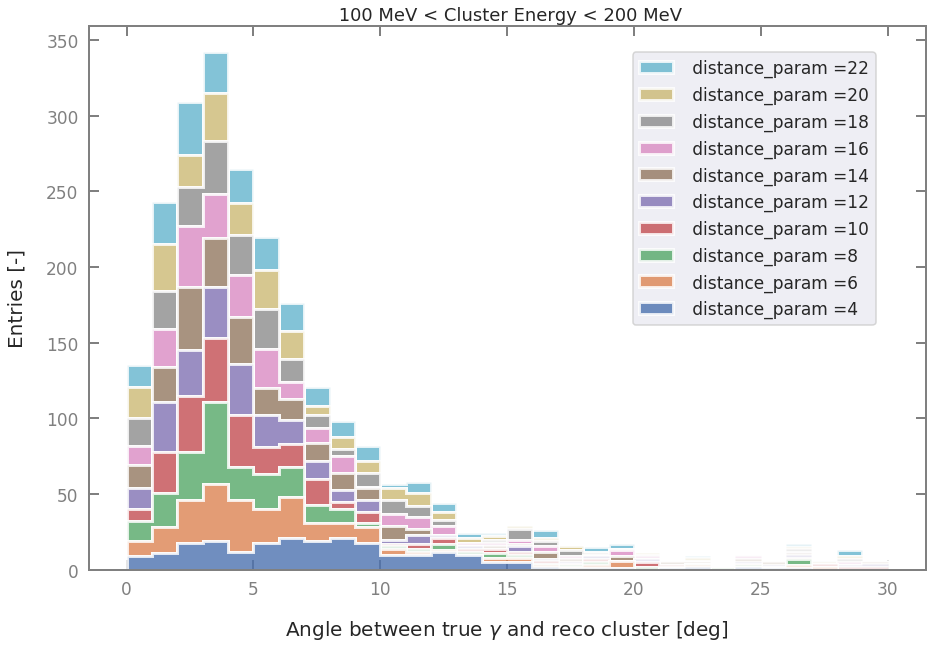

In [16]:
# Define lists for angles for corresponding energies of the cluster
angles_0_100, angles_100_200, angles_200_300, angles_300_400, angles_400_500, angles_500_inf = [], [], [], [], [], []

for i, entry in enumerate(DistanceParam_List):
    for clust in range(len(entry.reco_edep)):
        if entry.reco_edep[clust]>0 and entry.reco_edep[clust]<100:
            angles_0_100.append(entry.angles[clust])
        if entry.reco_edep[clust]>100 and entry.reco_edep[clust]<200:
            angles_100_200.append(entry.angles[clust])
        if entry.reco_edep[clust]>200 and entry.reco_edep[clust]<300:
            angles_200_300.append(entry.angles[clust])
        if entry.reco_edep[clust]>300 and entry.reco_edep[clust]<400:
            angles_300_400.append(entry.angles[clust])
        if entry.reco_edep[clust]>400 and entry.reco_edep[clust]<500:
            angles_400_500.append(entry.angles[clust])
        if entry.reco_edep[clust]>500:
            angles_500_inf.append(entry.angles[clust])

# TODO: THIS IS SUPER-DUMB, MAKE IT AS A FUNCTION OF NUMBER_OF_PARAMS
param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9 = [], [], [], [], [], [], [], [], [], []
for clust in range(len(angles_100_200)):
    param_0.append(angles_100_200[clust][0])
    param_1.append(angles_100_200[clust][1])
    param_2.append(angles_100_200[clust][2])
    param_3.append(angles_100_200[clust][3])
    param_4.append(angles_100_200[clust][4])
    param_5.append(angles_100_200[clust][5])
    param_6.append(angles_100_200[clust][6])
    param_7.append(angles_100_200[clust][7])
    param_8.append(angles_100_200[clust][8])
    param_9.append(angles_100_200[clust][9])

E_100_200 = [param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9]

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 30
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure()
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Produce histogram
n, bins, patches = plt.hist(E_100_200, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=True, linewidth=3, alpha=0.8)

# Legend
entry_0 = ' distance_param =' + str(DistanceParam_List[0].params[0])
entry_1 = ' distance_param =' + str(DistanceParam_List[0].params[1])
entry_2 = ' distance_param =' + str(DistanceParam_List[0].params[2])
entry_3 = ' distance_param =' + str(DistanceParam_List[0].params[3])
entry_4 = ' distance_param =' + str(DistanceParam_List[0].params[4])
entry_5 = ' distance_param =' + str(DistanceParam_List[0].params[5])
entry_6 = ' distance_param =' + str(DistanceParam_List[0].params[6])
entry_7 = ' distance_param =' + str(DistanceParam_List[0].params[7])
entry_8 = ' distance_param =' + str(DistanceParam_List[0].params[8])
entry_9 = ' distance_param =' + str(DistanceParam_List[0].params[9])
plt.legend([entry_9, entry_8, entry_7, entry_6, entry_5, entry_4, entry_3, entry_2, entry_1, entry_0], loc=[0.65,0.45], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)
plt.title(' 100 MeV < Cluster Energy < 200 MeV')

fig_name = 'angle_true_dir_reco_cluster_dir_10000ev_100-200MeV_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'

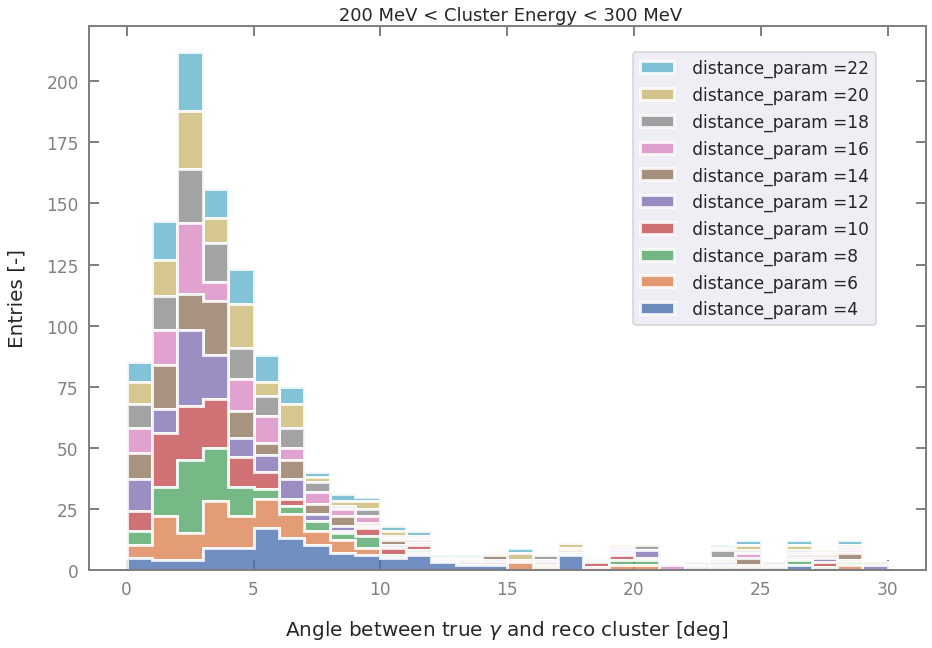

In [17]:
# Define lists for angles for corresponding energies of the cluster
angles_0_100, angles_100_200, angles_200_300, angles_300_400, angles_400_500, angles_500_inf = [], [], [], [], [], []

for i, entry in enumerate(DistanceParam_List):
    for clust in range(len(entry.reco_edep)):
        if entry.reco_edep[clust]>0 and entry.reco_edep[clust]<100:
            angles_0_100.append(entry.angles[clust])
        if entry.reco_edep[clust]>100 and entry.reco_edep[clust]<200:
            angles_100_200.append(entry.angles[clust])
        if entry.reco_edep[clust]>200 and entry.reco_edep[clust]<300:
            angles_200_300.append(entry.angles[clust])
        if entry.reco_edep[clust]>300 and entry.reco_edep[clust]<400:
            angles_300_400.append(entry.angles[clust])
        if entry.reco_edep[clust]>400 and entry.reco_edep[clust]<500:
            angles_400_500.append(entry.angles[clust])
        if entry.reco_edep[clust]>500:
            angles_500_inf.append(entry.angles[clust])

# TODO: THIS IS SUPER-DUMB, MAKE IT AS A FUNCTION OF NUMBER_OF_PARAMS
param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9 = [], [], [], [], [], [], [], [], [], []
for clust in range(len(angles_200_300)):
    param_0.append(angles_200_300[clust][0])
    param_1.append(angles_200_300[clust][1])
    param_2.append(angles_200_300[clust][2])
    param_3.append(angles_200_300[clust][3])
    param_4.append(angles_200_300[clust][4])
    param_5.append(angles_200_300[clust][5])
    param_6.append(angles_200_300[clust][6])
    param_7.append(angles_200_300[clust][7])
    param_8.append(angles_200_300[clust][8])
    param_9.append(angles_200_300[clust][9])

E_200_300 = [param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9]

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 30
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure()
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Produce histogram
n, bins, patches = plt.hist(E_200_300, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=True, linewidth=3, alpha=0.8)

# Legend
entry_0 = ' distance_param =' + str(DistanceParam_List[0].params[0])
entry_1 = ' distance_param =' + str(DistanceParam_List[0].params[1])
entry_2 = ' distance_param =' + str(DistanceParam_List[0].params[2])
entry_3 = ' distance_param =' + str(DistanceParam_List[0].params[3])
entry_4 = ' distance_param =' + str(DistanceParam_List[0].params[4])
entry_5 = ' distance_param =' + str(DistanceParam_List[0].params[5])
entry_6 = ' distance_param =' + str(DistanceParam_List[0].params[6])
entry_7 = ' distance_param =' + str(DistanceParam_List[0].params[7])
entry_8 = ' distance_param =' + str(DistanceParam_List[0].params[8])
entry_9 = ' distance_param =' + str(DistanceParam_List[0].params[9])
plt.legend([entry_9, entry_8, entry_7, entry_6, entry_5, entry_4, entry_3, entry_2, entry_1, entry_0], loc=[0.65,0.45], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)
plt.title(' 200 MeV < Cluster Energy < 300 MeV')

fig_name = 'angle_true_dir_reco_cluster_dir_10000ev_200-300MeV_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'

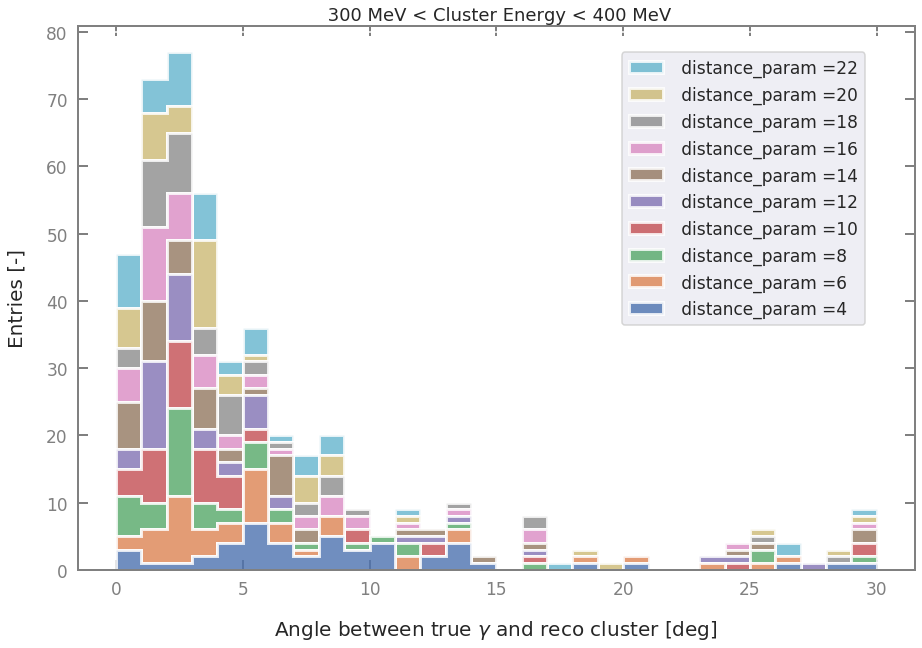

In [18]:
# Define lists for angles for corresponding energies of the cluster
angles_0_100, angles_100_200, angles_200_300, angles_300_400, angles_400_500, angles_500_inf = [], [], [], [], [], []

for i, entry in enumerate(DistanceParam_List):
    for clust in range(len(entry.reco_edep)):
        if entry.reco_edep[clust]>0 and entry.reco_edep[clust]<100:
            angles_0_100.append(entry.angles[clust])
        if entry.reco_edep[clust]>100 and entry.reco_edep[clust]<200:
            angles_100_200.append(entry.angles[clust])
        if entry.reco_edep[clust]>200 and entry.reco_edep[clust]<300:
            angles_200_300.append(entry.angles[clust])
        if entry.reco_edep[clust]>300 and entry.reco_edep[clust]<400:
            angles_300_400.append(entry.angles[clust])
        if entry.reco_edep[clust]>400 and entry.reco_edep[clust]<500:
            angles_400_500.append(entry.angles[clust])
        if entry.reco_edep[clust]>500:
            angles_500_inf.append(entry.angles[clust])

# TODO: THIS IS SUPER-DUMB, MAKE IT AS A FUNCTION OF NUMBER_OF_PARAMS
param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9 = [], [], [], [], [], [], [], [], [], []
for clust in range(len(angles_300_400)):
    param_0.append(angles_300_400[clust][0])
    param_1.append(angles_300_400[clust][1])
    param_2.append(angles_300_400[clust][2])
    param_3.append(angles_300_400[clust][3])
    param_4.append(angles_300_400[clust][4])
    param_5.append(angles_300_400[clust][5])
    param_6.append(angles_300_400[clust][6])
    param_7.append(angles_300_400[clust][7])
    param_8.append(angles_300_400[clust][8])
    param_9.append(angles_300_400[clust][9])

E_300_400 = [param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9]

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 30
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure()
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Produce histogram
n, bins, patches = plt.hist(E_300_400, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=True, linewidth=3, alpha=0.8)

# Legend
entry_0 = ' distance_param =' + str(DistanceParam_List[0].params[0])
entry_1 = ' distance_param =' + str(DistanceParam_List[0].params[1])
entry_2 = ' distance_param =' + str(DistanceParam_List[0].params[2])
entry_3 = ' distance_param =' + str(DistanceParam_List[0].params[3])
entry_4 = ' distance_param =' + str(DistanceParam_List[0].params[4])
entry_5 = ' distance_param =' + str(DistanceParam_List[0].params[5])
entry_6 = ' distance_param =' + str(DistanceParam_List[0].params[6])
entry_7 = ' distance_param =' + str(DistanceParam_List[0].params[7])
entry_8 = ' distance_param =' + str(DistanceParam_List[0].params[8])
entry_9 = ' distance_param =' + str(DistanceParam_List[0].params[9])
plt.legend([entry_9, entry_8, entry_7, entry_6, entry_5, entry_4, entry_3, entry_2, entry_1, entry_0], loc=[0.65,0.45], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)
plt.title(' 300 MeV < Cluster Energy < 400 MeV')

fig_name = 'angle_true_dir_reco_cluster_dir_10000ev_300-400MeV_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'

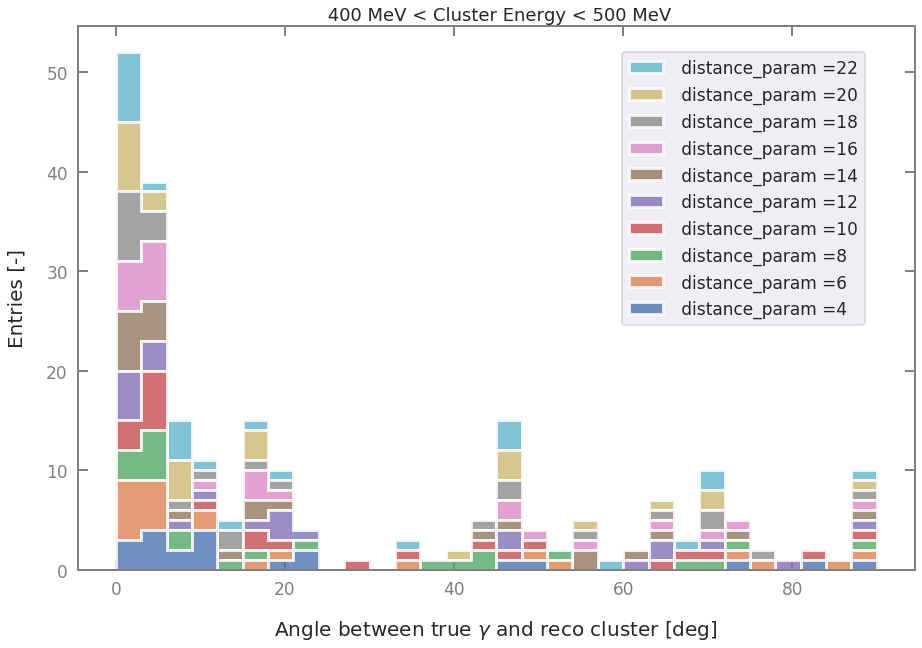

In [19]:
# Define lists for angles for corresponding energies of the cluster
angles_0_100, angles_100_200, angles_200_300, angles_300_400, angles_400_500, angles_500_inf = [], [], [], [], [], []

for i, entry in enumerate(DistanceParam_List):
    for clust in range(len(entry.reco_edep)):
        if entry.reco_edep[clust]>0 and entry.reco_edep[clust]<100:
            angles_0_100.append(entry.angles[clust])
        if entry.reco_edep[clust]>100 and entry.reco_edep[clust]<200:
            angles_100_200.append(entry.angles[clust])
        if entry.reco_edep[clust]>200 and entry.reco_edep[clust]<300:
            angles_200_300.append(entry.angles[clust])
        if entry.reco_edep[clust]>300 and entry.reco_edep[clust]<400:
            angles_300_400.append(entry.angles[clust])
        if entry.reco_edep[clust]>400 and entry.reco_edep[clust]<500:
            angles_400_500.append(entry.angles[clust])
        if entry.reco_edep[clust]>500:
            angles_500_inf.append(entry.angles[clust])

# TODO: THIS IS SUPER-DUMB, MAKE IT AS A FUNCTION OF NUMBER_OF_PARAMS
param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9 = [], [], [], [], [], [], [], [], [], []
for clust in range(len(angles_400_500)):
    param_0.append(angles_400_500[clust][0])
    param_1.append(angles_400_500[clust][1])
    param_2.append(angles_400_500[clust][2])
    param_3.append(angles_400_500[clust][3])
    param_4.append(angles_400_500[clust][4])
    param_5.append(angles_400_500[clust][5])
    param_6.append(angles_400_500[clust][6])
    param_7.append(angles_400_500[clust][7])
    param_8.append(angles_400_500[clust][8])
    param_9.append(angles_400_500[clust][9])

E_400_500 = [param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9]

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 90
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure()
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Produce histogram
n, bins, patches = plt.hist(E_400_500, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=True, linewidth=3, alpha=0.8)

# Legend
entry_0 = ' distance_param =' + str(DistanceParam_List[0].params[0])
entry_1 = ' distance_param =' + str(DistanceParam_List[0].params[1])
entry_2 = ' distance_param =' + str(DistanceParam_List[0].params[2])
entry_3 = ' distance_param =' + str(DistanceParam_List[0].params[3])
entry_4 = ' distance_param =' + str(DistanceParam_List[0].params[4])
entry_5 = ' distance_param =' + str(DistanceParam_List[0].params[5])
entry_6 = ' distance_param =' + str(DistanceParam_List[0].params[6])
entry_7 = ' distance_param =' + str(DistanceParam_List[0].params[7])
entry_8 = ' distance_param =' + str(DistanceParam_List[0].params[8])
entry_9 = ' distance_param =' + str(DistanceParam_List[0].params[9])
plt.legend([entry_9, entry_8, entry_7, entry_6, entry_5, entry_4, entry_3, entry_2, entry_1, entry_0], loc=[0.65,0.45], prop={'size': 17}) # loc='upper right'

# Axis labels
plt.xlabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)
plt.title(' 400 MeV < Cluster Energy < 500 MeV')

fig_name = 'angle_true_dir_reco_cluster_dir_10000ev_400-500MeV_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'

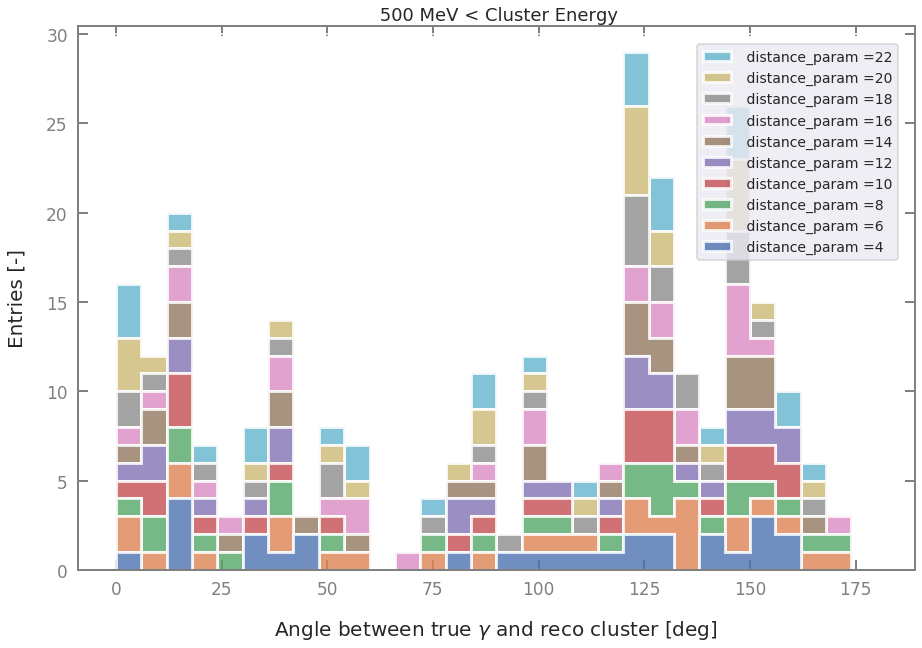

In [20]:
# Define lists for angles for corresponding energies of the cluster
angles_0_100, angles_100_200, angles_200_300, angles_300_400, angles_400_500, angles_500_inf = [], [], [], [], [], []

for i, entry in enumerate(DistanceParam_List):
    for clust in range(len(entry.reco_edep)):
        if entry.reco_edep[clust]>0 and entry.reco_edep[clust]<100:
            angles_0_100.append(entry.angles[clust])
        if entry.reco_edep[clust]>100 and entry.reco_edep[clust]<200:
            angles_100_200.append(entry.angles[clust])
        if entry.reco_edep[clust]>200 and entry.reco_edep[clust]<300:
            angles_200_300.append(entry.angles[clust])
        if entry.reco_edep[clust]>300 and entry.reco_edep[clust]<400:
            angles_300_400.append(entry.angles[clust])
        if entry.reco_edep[clust]>400 and entry.reco_edep[clust]<500:
            angles_400_500.append(entry.angles[clust])
        if entry.reco_edep[clust]>500:
            angles_500_inf.append(entry.angles[clust])

# TODO: THIS IS SUPER-DUMB, MAKE IT AS A FUNCTION OF NUMBER_OF_PARAMS
param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9 = [], [], [], [], [], [], [], [], [], []
for clust in range(len(angles_500_inf)):
    param_0.append(angles_500_inf[clust][0])
    param_1.append(angles_500_inf[clust][1])
    param_2.append(angles_500_inf[clust][2])
    param_3.append(angles_500_inf[clust][3])
    param_4.append(angles_500_inf[clust][4])
    param_5.append(angles_500_inf[clust][5])
    param_6.append(angles_500_inf[clust][6])
    param_7.append(angles_500_inf[clust][7])
    param_8.append(angles_500_inf[clust][8])
    param_9.append(angles_500_inf[clust][9])

E_500_inf = [param_0 , param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9]

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define histogram range and binning
x_min    = 0
x_max    = 180
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)

# Define parameters of the frame
fig = plt.figure()
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Produce histogram
n, bins, patches = plt.hist(E_500_inf, bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=True, linewidth=3, alpha=0.8)

# Legend
entry_0 = ' distance_param =' + str(DistanceParam_List[0].params[0])
entry_1 = ' distance_param =' + str(DistanceParam_List[0].params[1])
entry_2 = ' distance_param =' + str(DistanceParam_List[0].params[2])
entry_3 = ' distance_param =' + str(DistanceParam_List[0].params[3])
entry_4 = ' distance_param =' + str(DistanceParam_List[0].params[4])
entry_5 = ' distance_param =' + str(DistanceParam_List[0].params[5])
entry_6 = ' distance_param =' + str(DistanceParam_List[0].params[6])
entry_7 = ' distance_param =' + str(DistanceParam_List[0].params[7])
entry_8 = ' distance_param =' + str(DistanceParam_List[0].params[8])
entry_9 = ' distance_param =' + str(DistanceParam_List[0].params[9])
plt.legend([entry_9, entry_8, entry_7, entry_6, entry_5, entry_4, entry_3, entry_2, entry_1, entry_0], loc=[0.74,0.57], prop={'size': 14}) # loc='upper right'

# Axis labels
plt.xlabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)
plt.title(' 500 MeV < Cluster Energy')

fig_name = 'angle_true_dir_reco_cluster_dir_10000ev_more_than_500MeV_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'

# Assign clusters <---> true showers and calculate the angle [in degrees] between cluster_direction and true_gamma_direction 

In [21]:
class AnalysedData(object):
    '''
    Class for the storage of variables of events which passed the selection.
    The attributes are added in a dynamic way.
    This class can be used as:
    ana = AnalysedData()
    ana.attribute = someobject
    Use AnalysedData.__dict__ to show attributes.
    '''

    # Defined attributes
    # -------------------------------------
    '''
    angle       # angle between true_gamma and reconstructed cluster_gamma [deg]
    true_ekin
    true_edep
    reco_edep   # energy of the reconstructed cluster_gamma [MeV]
    '''

    pass

In [22]:
AnalysisList = []

for i, res in enumerate(ResultsList):

    
    # Create matrix for distances between cluster_i and true_shower_j:
    if not (res.clusters_n_clusters or res.true_n_gammas): continue

    # CUT: WANT TO HAVE SAME NUMBER OF TRUE GAMMAS AND TRUE CLUSTERS
    if res.true_n_gammas != 2 or res.clusters_n_clusters != 2: continue

    #print(' event_id: ', res.event_id)

    dist_mat = np.zeros([res.clusters_n_clusters, res.true_n_gammas]) # columns = number of clusters, rows = number of true_gammas
    '''
    print(' clusters start positions: ')
    for cl in range(res.clusters_n_clusters):
        print(res.clusters_start[cl])

    print(' true gammas start positions: ')
    for gamma in range(res.true_n_gammas):
        print(res.true_gamma_first_step[gamma])
   '''
    for cluster in range(res.clusters_n_clusters):
        for true_gamma in range(res.true_n_gammas):
            dist_mat[cluster][true_gamma] = np.linalg.norm(res.clusters_start[cluster]-res.true_gamma_first_step[true_gamma])

    # Store assignments
    assignments = [] # list of U arrays (where U is min(n_clusters,n_true_gammas)). First array entry: cluster index, second array: true_gamma index.
    for i in range(min(dist_mat.shape)):
        indices = np.argwhere(dist_mat.min() == dist_mat)

        assignments.append(indices[0])

        dist_mat[indices[0][0],:] = 999
        dist_mat[:,indices[0][1]] = 999

    # Calculate dot products between assigned showers
    for i, ass in enumerate(assignments):
        #print(' i: ', i)
        analysis_data = AnalysedData()
        analysis_data.angle     = np.arccos(np.dot(res.clusters_dir[ass[0]],res.true_gamma_dir[ass[1]]))*360/(2*np.pi)
        analysis_data.true_ekin = res.true_gamma_ekin[ass[1]]
        analysis_data.true_edep = res.true_gamma_edep[ass[1]]
        analysis_data.reco_edep = res.clusters_energy[ass[0]]
        #print(' angle [deg]: \t \t \t ',          analysis_data.angle)
        #print(' true gamma energy [MeV]: \t ',    analysis_data.true_ekin)
        #print(' true edep [MeV]: \t \t ',         analysis_data.true_edep)
        #print(' cluster energy [MeV]: \t \t ',    analysis_data.reco_edep)
    #print(' ------------------------------------------------------------------------------- ')


        AnalysisList.append(analysis_data)

In [23]:
import math

angles    = []
true_ekin = []
true_edep = []
reco_edep = []

for i, entry in enumerate(AnalysisList):
   
    if math.isnan(entry.angle) or math.isnan(entry.true_ekin) or math.isnan(entry.true_edep) or math.isnan(entry.reco_edep):
        continue
        
    #print(' i: ', i)
    #print(' entry:     ', entry)
    #print(' angle:     ', entry.angle)
    #print(' true ekin: ', entry.true_ekin)
    #print(' true edep: ', entry.true_edep)
    #print(' reco edep: ', entry.reco_edep)
    angles.append(entry.angle)
    true_ekin.append(entry.true_ekin)
    true_edep.append(entry.true_edep)
    reco_edep.append(entry.reco_edep)

# Plot angle between true gamma and reconstructed cluster

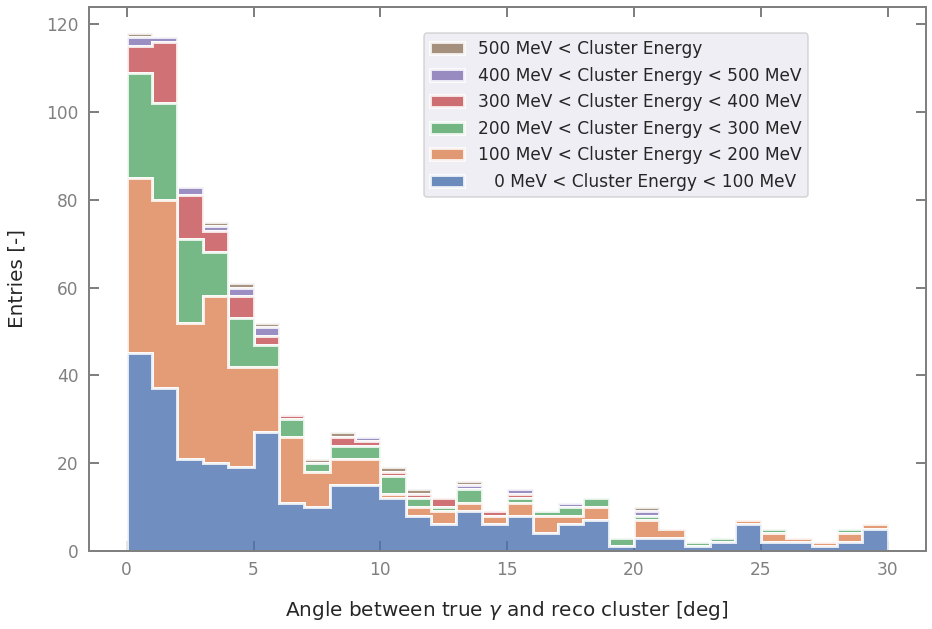

In [24]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper


# Define histogram range and binning
x_min    = 0
x_max    = 30
n_bins_x = 30
x_bins = np.linspace(x_min,x_max,n_bins_x+1)


# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
#fig.patch.set_facecolor('white')
#fig.patch.set_alpha(0.0)
ax = fig.add_subplot(111)
#ax.patch.set_facecolor('#ababab') # #ababab
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)


# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                colors='0.5',                                       # color of the ticks ('black', '0.5')
                bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                zorder = 10.,                                       # tick and label zorder
                pad = 10.,                                          # distance between ticks and tick labels
                labelsize = 17,                                     # size of the tick labels
                labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
                #labelrotation=45.                                  # rotation of the labels
                #grid_color='black',                                # grid
                #grid_alpha=0.0,
                #grid_linewidth=1.0,
# colors='black','0.5'


angles_0_100   = []
angles_100_200 = []
angles_200_300 = []
angles_300_400 = []
angles_400_500 = []
angles_500_inf = []


for i, ang in enumerate(angles):
    if reco_edep[i] > 0 and reco_edep[i] < 100:
        angles_0_100.append(ang)
    if reco_edep[i] > 100 and reco_edep[i] < 200:
        angles_100_200.append(ang)
    if reco_edep[i] > 200 and reco_edep[i] < 300:
        angles_200_300.append(ang)
    if reco_edep[i] > 300 and reco_edep[i] < 400:
        angles_300_400.append(ang)
    if reco_edep[i] > 400 and reco_edep[i] < 500:
        angles_400_500.append(ang)
    if reco_edep[i] > 500:
        angles_500_inf.append(ang)

# Plot masses
n_0, bins_0, patches_0 = plt.hist([angles_0_100,angles_100_200,angles_200_300,angles_300_400,angles_400_500,angles_500_inf], bins=n_bins_x, range=[x_min,x_max], histtype='stepfilled', stacked=True, linewidth=3, alpha=0.8)

# Legend
#unfiducialized = 'not fiducialized'
entry_0 = '   0 MeV < Cluster Energy < 100 MeV'
entry_1 = '100 MeV < Cluster Energy < 200 MeV'
entry_2 = '200 MeV < Cluster Energy < 300 MeV'
entry_3 = '300 MeV < Cluster Energy < 400 MeV'
entry_4 = '400 MeV < Cluster Energy < 500 MeV'
entry_5 = '500 MeV < Cluster Energy '
plt.legend([entry_5, entry_4, entry_3, entry_2, entry_1, entry_0], loc=[0.4,0.65], prop={'size': 17}) # loc='upper right'


# Axis labels
plt.xlabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20, labelpad=20)
plt.ylabel('Entries [-]', fontsize=20, labelpad=20)


#plt.axvline(134.9770, color='r', linestyle='dashed', linewidth=2)


# Save figure
#fig_name = '0' + folder + '_pi0_mass_peak.png'
fig_name = 'angle_true_dir_reco_cluster_dir_10000ev_distParam_10_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching_3.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'
#plt.show()

# Print angle vs. true edep

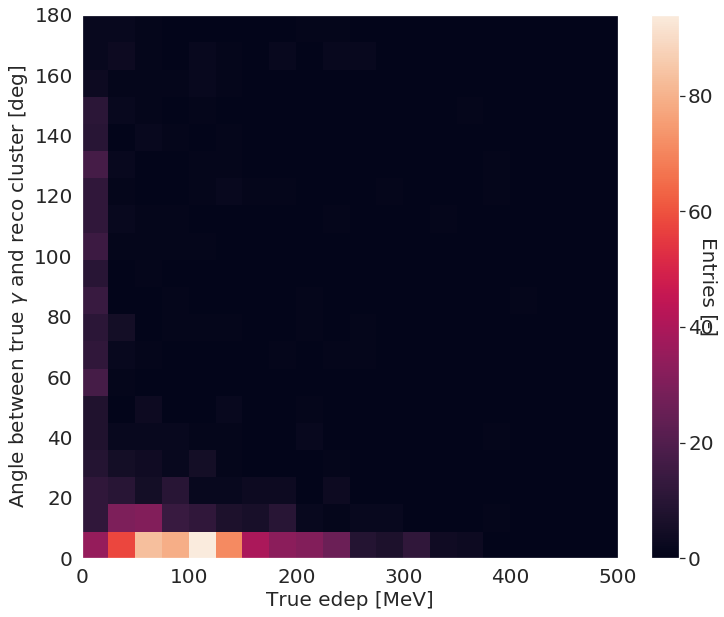

In [25]:
# Size
import seaborn
seaborn.set(rc={'figure.figsize':(12,10),})

fig, ax = plt.subplots()

# Binning
#x_min  = -0.5
#x_max  = 12.5
#y_min  = -0.5
#y_max  = 12.5
#x_bins = np.arange(x_min,x_max+1,step=1.)
#y_bins = np.arange(y_min,y_max+1,step=1.)
x_min    = 0
x_max    = 500
y_min    = 0
y_max    = 180
n_bins_x = 20 #int(abs(x_max)-abs(x_min)+1)
n_bins_y = 20 #int(abs(y_max)-abs(y_min)+1)
x_bins = np.linspace(x_min,x_max,n_bins_x+1)
y_bins = np.linspace(y_min,y_max,n_bins_y+1)
#print(x_bins)
#print(y_bins)

plt.hist2d(true_edep, angles, bins=[x_bins,y_bins])#, cmap=plt.cm.viridis)
# Color maps: viridis, plasma, magma, inferno

# Colorbar
#help(colorbar)
colorbar = plt.colorbar()
colorbar.set_label('Entries [-]', rotation=270, fontsize=20)
colorbar.ax.tick_params(labelsize=20)
#v1 = np.linspace(z.min(), z.max(), 8, endpoint=True)
#plt.colorbar(ticks=v1)

# Axes
plt.xlabel('True edep [MeV]', fontsize=20)
plt.ylabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20)
plt.tick_params(labelsize=20)

#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))

fig_name = 'angle_true_dir_reco_cluster_vs_true_edep_10000ev_distParam_10_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'
plt.show()
plt.close()

# Print angle vs. reco edep

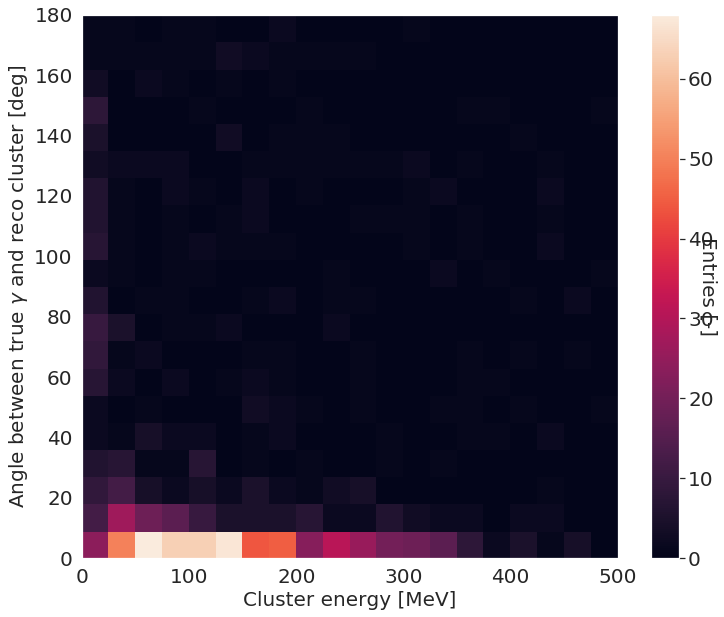

In [26]:
# Size
import seaborn
seaborn.set(rc={'figure.figsize':(12,10),})

fig, ax = plt.subplots()

# Binning
#x_min  = -0.5
#x_max  = 12.5
#y_min  = -0.5
#y_max  = 12.5
#x_bins = np.arange(x_min,x_max+1,step=1.)
#y_bins = np.arange(y_min,y_max+1,step=1.)
x_min    = 0
x_max    = 500
y_min    = 0
y_max    = 180
n_bins_x = 20 #int(abs(x_max)-abs(x_min)+1)
n_bins_y = 20 #int(abs(y_max)-abs(y_min)+1)
x_bins = np.linspace(x_min,x_max,n_bins_x+1)
y_bins = np.linspace(y_min,y_max,n_bins_y+1)
#print(x_bins)
#print(y_bins)

plt.hist2d(reco_edep, angles, bins=[x_bins,y_bins])#, cmap=plt.cm.viridis)
# Color maps: viridis, plasma, magma, inferno

# Colorbar
#help(colorbar)
colorbar = plt.colorbar()
colorbar.set_label('Entries [-]', rotation=270, fontsize=20)
colorbar.ax.tick_params(labelsize=20)
#v1 = np.linspace(z.min(), z.max(), 8, endpoint=True)
#plt.colorbar(ticks=v1)

# Axes
plt.xlabel('Cluster energy [MeV]', fontsize=20)
plt.ylabel('Angle between true $\gamma$ and reco cluster [deg]', fontsize=20)
plt.tick_params(labelsize=20)

#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))

fig_name = 'angle_true_dir_reco_cluster_vs_reco_edep_10000ev_distParam_10_refit_dir_true_proximity_shower_start_ppn_vertex_ppn_new_matching.png'
plt.savefig(fig_name, dpi=400) # bbox_inches='tight'
plt.show()
plt.close()